In [99]:
# coding: UTF-8


import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torchinfo import summary
from model.layers import Base_Module, Attention_HSI_Block


%matplotlib inline
sns.set()

In [33]:
x = torch.rand((1, 31))
y = torch.rand((1, 31))
((x - y) ** 2).mean()

tensor(0.1190)

In [123]:
def normalize(data):
    return (data - data.min()) / (data.max() - data.min())


def psnr(x, y):
    if len(x.shape) == 4:
        _, c, _, _ = x.shape
    elif len(x.shape) == 3:
        c, _, _ = x.shape
    else:
        print('shiran')
    all_psnr = 10. * torch.Tensor([torch.log10(y[:, i].max() ** 2. / ((x[:, i] - y[:, i]) ** 2)).mean() for i in range(c)])
    return torch.mean(all_psnr)

def sam(x, y):
    if len(x.shape) == 4:
        x_sqrt = torch.norm(x, dim=1)
        y_sqrt = torch.norm(y, dim=1)
        # print('sam')
        # print(x_sqrt.shape, y_sqrt.shape)
        xy = torch.sum(x * y, dim=1)
    elif len(x.shape) == 3:
        x_sqrt = torch.norm(x, dim=0)
        y_sqrt = torch.norm(y, dim=0)
        # print('sam')
        # print(x_sqrt.shape, y_sqrt.shape)
        xy = torch.sum(x * y, dim=0)
    metrics = xy / (x_sqrt * y_sqrt + 1e-6)
    angle = torch.acos(metrics)
    return torch.mean(angle)
    
    
    
class SSAttention(Base_Module):

    def __init__(self, input_ch: int, output_ch: int, *args, feature_num: int=64,
                 layer_num: int=9, **kwargs) -> None:
        super().__init__()
        ratio = kwargs.get('ratio', 4)
        self.output_ch = output_ch
        self.input_conv = torch.nn.Conv2d(input_ch, output_ch, 3, 1, 1)
        self.attention_layers = torch.nn.ModuleDict({f'Attn_{i}': Attention_HSI_Block(output_ch, output_ch, feature_num=feature_num, ratio=ratio) for i in range(layer_num)})
        self.residual_layers = torch.nn.ModuleDict({f'Res_{i}': torch.nn.Conv2d(output_ch, output_ch, 3, 1, 1) for i in range(layer_num)})
        self.output_conv = torch.nn.Conv2d(output_ch, output_ch, 3, 1, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        x = self.input_conv(x)
        x_in = x
        for attn_layer, res_layer in zip(self.attention_layers.values(),
                                         self.residual_layers.values()):
            attn_x = attn_layer(x)
            res_x = res_layer(x)
            x = x_in + attn_x + res_x
        x = self.output_conv(x)
        return x

    def get_attention_map(self, x: torch.Tensor):

        spatial_map = {}
        spectral_map = {}
        x = self.input_conv(x)
        x_in = x
        for i, (attn_layer, res_layer) in enumerate(zip(self.attention_layers.values(),
                                         self.residual_layers.values())):
            attn_x, attn_map = attn_layer.get_attention_map(x)
            spatial_map[f'Spatial_{i}'] = attn_map[0]
            spectral_map[f'Spectral_{i}'] = attn_map[1]
            res_x = res_layer(x)
            x = x_in + attn_x + res_x
        x = self.output_conv(x)
        return spatial_map, spectral_map

    def plot_attention_map(self, x: torch.Tensor, save_dir: str='Attention', *args, **kwargs):

        mat_mode = kwargs.get('mat_mode', False)
        row, col = int(np.ceil(np.sqrt(self.output_ch))), int(np.ceil(np.sqrt(self.output_ch)))
        os.makedirs(save_dir, exist_ok=True)
        spatial_map , spectral_map = self.get_attention_map(x)
        for layer_name, feature in spatial_map.items():
            print(layer_name, feature.shape)
        for layer_name, feature in spectral_map.items():
            print(layer_name, feature.shape)
        return spatial_map, spectral_map
        # for layer_name, feature in spatial_map.items():
        #     feature = normalize(feature.permute((1, 0, 2, 3)))

In [35]:
model = SSAttention(1, 31)
x = torch.rand((1, 1, 512, 512))
y = torch.rand((1, 31, 512, 512))
print(psnr(x, y))
spatial_map, spectral_map = model.plot_attention_map(x)

tensor(13.0207)
Spatial_0 torch.Size([1, 31, 512, 512])
Spatial_1 torch.Size([1, 31, 512, 512])
Spatial_2 torch.Size([1, 31, 512, 512])
Spatial_3 torch.Size([1, 31, 512, 512])
Spatial_4 torch.Size([1, 31, 512, 512])
Spatial_5 torch.Size([1, 31, 512, 512])
Spatial_6 torch.Size([1, 31, 512, 512])
Spatial_7 torch.Size([1, 31, 512, 512])
Spatial_8 torch.Size([1, 31, 512, 512])
Spectral_0 torch.Size([1, 31, 1, 1])
Spectral_1 torch.Size([1, 31, 1, 1])
Spectral_2 torch.Size([1, 31, 1, 1])
Spectral_3 torch.Size([1, 31, 1, 1])
Spectral_4 torch.Size([1, 31, 1, 1])
Spectral_5 torch.Size([1, 31, 1, 1])
Spectral_6 torch.Size([1, 31, 1, 1])
Spectral_7 torch.Size([1, 31, 1, 1])
Spectral_8 torch.Size([1, 31, 1, 1])


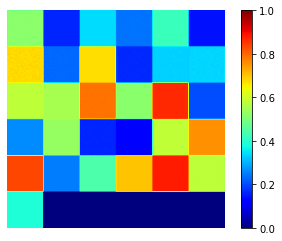

In [47]:
spatial = spatial_map['Spatial_0']
row, col = int(np.ceil(np.sqrt(31))),int(np.ceil(np.sqrt(31)))
plot_feature = normalize(spatial.permute(1, 0, 2, 3))
plot_feature = torchvision.utils.make_grid(feature, nrow=row, padding=0).detach().numpy().copy()  # grid tile
plot_feature = plot_feature[0] * .299 + plot_feature[1] * 0.587 + plot_feature[2] * 0.114  # translate from rgb 2 grayscale
plt.imshow(plot_feature, cmap='jet')
plt.axis('off')
plt.colorbar()
plt.show()

torch.Size([1, 31]) torch.Size([31, 1])
(31, 31)


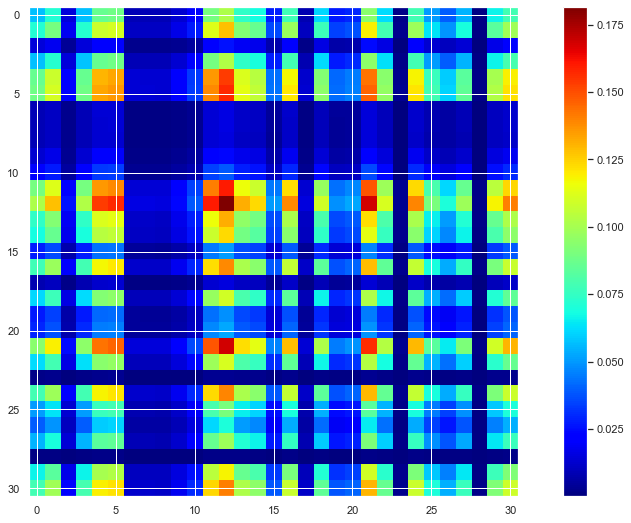

In [109]:
plt.figure(figsize=(16, 9))
spectral = spectral_map['Spectral_0'].squeeze(-1).squeeze(-1)
print(spectral.shape, spectral.T.shape)
plot_feature = spectral * spectral.T
plot_feature = plot_feature.detach().numpy().copy()
print(plot_feature.shape)
plt.imshow(plot_feature,, cmap='jet')
plt.colorbar()
plt.show()

torch.Size([1, 31]) torch.Size([31, 1])
(1, 31)


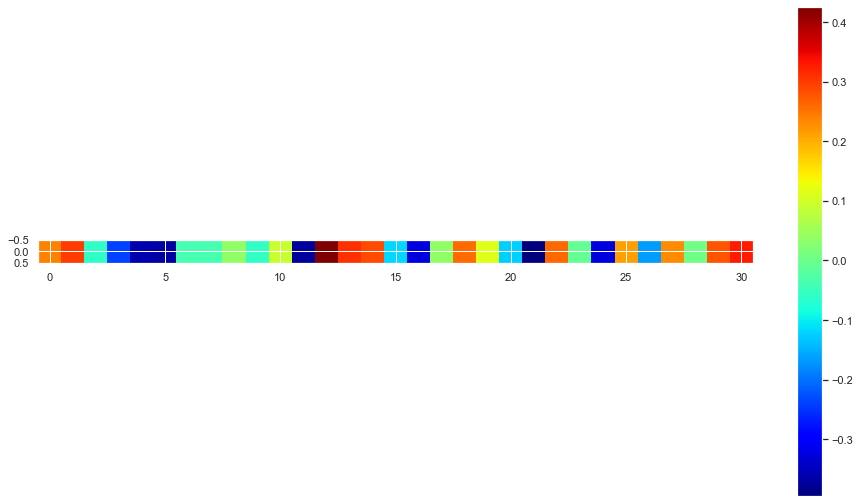

In [106]:
plt.figure(figsize=(16, 9))
spectral = spectral_map['Spectral_0'].squeeze(-1).squeeze(-1)
print(spectral.shape, spectral.T.shape)
plot_feature = spectral
plot_feature = plot_feature.detach().numpy().copy()
print(plot_feature.shape)
plt.imshow(plot_feature, cmap='jet')
plt.colorbar()
plt.show()

(31,)


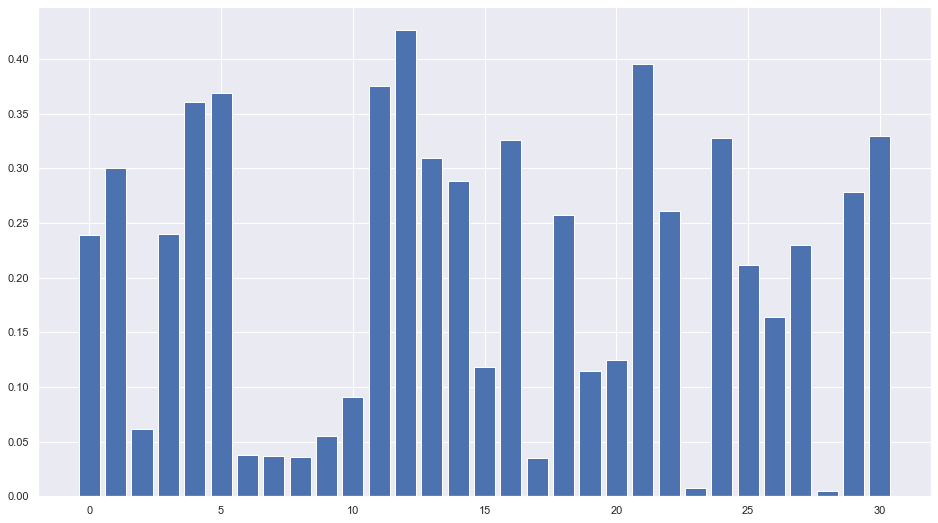

In [110]:
plt.figure(figsize=(16, 9))
spectral = spectral_map['Spectral_0'].squeeze(-1).squeeze(-1).squeeze()
# print(spectral.shape, spectral.T.shape)
# plot_feature = spectral * spectral.T
# print(plot_feature.shape)
plot_feature = spectral.detach().numpy().copy()
print(plot_feature.shape)
plt.bar(np.arange(plot_feature.shape[0]), np.abs(plot_feature))
plt.show()
# plt.imshow(plot_feature)
# plt.show()

In [98]:
for idx in range(y.shape[1]):
    print(idx, psnr(feature[:, idx], y[:, idx]))

0 tensor(5.7821)
1 tensor(1.9997)
2 tensor(2.6984)
3 tensor(2.5091)
4 tensor(13.0554)
5 tensor(4.8928)
6 tensor(14.2633)
7 tensor(12.6092)
8 tensor(13.5145)
9 tensor(5.2898)
10 tensor(13.0912)
11 tensor(11.9056)
12 tensor(7.2146)
13 tensor(12.8635)
14 tensor(9.0021)
15 tensor(4.3940)
16 tensor(6.5209)
17 tensor(13.7304)
18 tensor(14.0682)
19 tensor(6.2539)
20 tensor(4.7509)
21 tensor(14.9727)
22 tensor(7.1081)
23 tensor(5.5191)
24 tensor(5.4856)
25 tensor(11.6338)
26 tensor(10.4822)
27 tensor(4.6644)
28 tensor(3.5089)
29 tensor(10.6262)
30 tensor(4.1185)


[2.6605849266052246, 3.0517525672912598, 0.005264500621706247, 3.1372036933898926, 3.135759115219116, 3.1346068382263184, 3.1355292797088623, 0.0061790053732693195, 3.1361160278320312, 3.135394334793091, 2.5577216148376465, 0.009061858057975769, 0.005168091505765915, 0.00871005468070507, 0.005701825022697449, 3.112478017807007, 1.4741756916046143, 0.005224674940109253, 2.081613540649414, 0.00584966829046607, 0.005509811453521252, 3.133312702178955, 0.005130934529006481, 1.0725904703140259, 0.009060192853212357, 3.1340646743774414, 0.0069411322474479675, 0.005152619443833828, 0.005628755781799555, 3.13541841506958, 3.1351261138916016]
(31,)


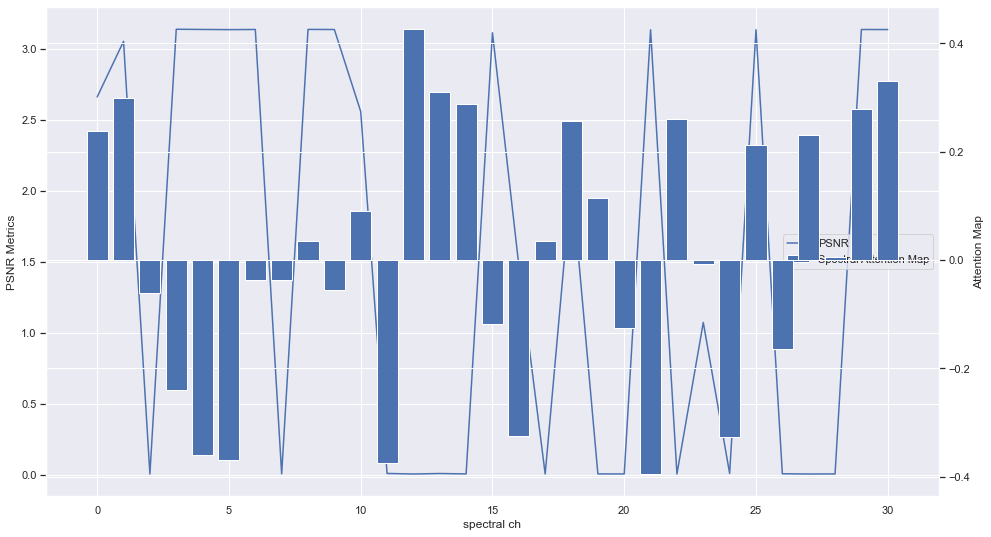

In [126]:
all_psnr = [psnr(spatial_map['Spatial_0'][:, idx], y[:, idx]) for idx in range(y.shape[1])]
all_sam = [sam(spatial_map['Spatial_0'][:, idx], y[:, idx]).item() for idx in range(y.shape[1])]
print(all_sam)
fig = plt.figure(figsize=(16, 9))
ax1 = fig.add_subplot(111)
plt.plot(all_sam, label='PSNR')
ax2 = ax1.twinx()
spectral = spectral_map['Spectral_0'].squeeze(-1).squeeze(-1).squeeze()
plot_feature = spectral.detach().numpy().copy()
print(plot_feature.shape)
# plt.bar(np.arange(plot_feature.shape[0]), np.abs(plot_feature), label='Spectral Attention Map')\
plt.bar(np.arange(plot_feature.shape[0]), plot_feature, label='Spectral Attention Map')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2)

ax1.set_xlabel('spectral ch')
ax1.set_ylabel('PSNR Metrics')
ax2.set_ylabel('Attention Map')
plt.show()

Text(0, 0.5, '$y=at+b$')

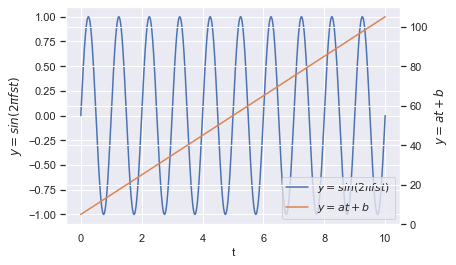

In [111]:

fig = plt.figure()
ax1 = fig.add_subplot(111)
t = np.linspace(0.0,10.0,1000)
fs = 1.0
y1 = np.sin(2.0*np.pi*fs*t)
ln1=ax1.plot(t, y1,'C0',label=r'$y=sin(2\pi fst)$')

ax2 = ax1.twinx()
y2 = 10.0*t + 5.0
ln2=ax2.plot(t,y2,'C1',label=r'$y=at+b$')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='lower right')

ax1.set_xlabel('t')
ax1.set_ylabel(r'$y=sin(2\pi fst)$')
ax1.grid(True)
ax2.set_ylabel(r'$y=at+b$')